# Simple Covid19 dataset analisys

In [1]:
!date

Thu Apr 16 09:51:02 UTC 2020


In [2]:
from google.cloud import bigquery
import pandas as pd

In [3]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

query = """
SELECT * FROM `bigquery-public-data.covid19_jhu_csse.deaths` 
where province_state is null and country_region = "United Kingdom" 
or country_region = "Italy" 
or country_region = "Germany"
or country_region = "Belgium"
"""
# or country_region = "Belgium"
# or country_region = "Korea, South"
# """

query_job = client.query(
    query,
    location="US",
)  # API request - starts the query

df = query_job.to_dataframe()
df.set_index('country_region', inplace=True) # use Country as index
df.drop(
    columns=['province_state', 'latitude', 'longitude', 'location_geom'], 
    inplace=True) # drops unused columns
df.rename(index={
    'Korea, South': 'Korea',
    'United Kingdom': 'UK',},
         inplace=True)
df

Client creating using default project: raffo-bq-xperiment


,_1_22_20,_1_23_20,_1_24_20,_1_25_20,_1_26_20,_1_27_20,_1_28_20,_1_29_20,_1_30_20,_1_31_20,...,_4_6_20,_4_7_20,_4_8_20,_4_9_20,_4_10_20,_4_11_20,_4_12_20,_4_13_20,_4_14_20,_4_15_20
country_region,,,,,,,,,,,,,,,,,,,,,
Italy,0,0,0,0,0,0,0,0,0,0,...,16523,17127,17669,18279,18849,19468,19899,20465,21067,21645
Belgium,0,0,0,0,0,0,0,0,0,0,...,1632,2035,2240,2523,3019,3346,3600,3903,4157,4440
UK,0,0,0,0,0,0,0,0,0,0,...,5373,6159,7097,7978,8958,9875,10612,11329,12107,12868
Germany,0,0,0,0,0,0,0,0,0,0,...,1810,2016,2349,2607,2767,2736,3022,3194,3294,3804


In [4]:
def transform(df, fn):
    '''Applies an incremental transformation to the series.
    
    Keyword arguments:
    @df: input dataframe
    @fn: the incremental transformation
        
    Examples:
    fn=lambda x,y: x - y will get the daily increase
    fn=lambda x,y: (x - y)/y will get the relative increase
    '''
    col = df.columns[1:]
    index = df.index
    transformed_series = df.apply(lambda line: [ fn(x,y) for (x,y) in (zip(line[1:], line))] , axis=1)
    transformed_df = pd.DataFrame(zip(*[country for country in transformed_series])).T
    transformed_df.set_index(index,inplace=True)
    transformed_df.columns = col
    return transformed_df   

In [5]:
linear_increase = transform(df, lambda x, y: x - y)

linear_increase

,_1_23_20,_1_24_20,_1_25_20,_1_26_20,_1_27_20,_1_28_20,_1_29_20,_1_30_20,_1_31_20,_2_1_20,...,_4_6_20,_4_7_20,_4_8_20,_4_9_20,_4_10_20,_4_11_20,_4_12_20,_4_13_20,_4_14_20,_4_15_20
country_region,,,,,,,,,,,,,,,,,,,,,
Italy,0,0,0,0,0,0,0,0,0,0,...,636,604,542,610,570,619,431,566,602,578
Belgium,0,0,0,0,0,0,0,0,0,0,...,185,403,205,283,496,327,254,303,254,283
UK,0,0,0,0,0,0,0,0,0,0,...,439,786,938,881,980,917,737,717,778,761
Germany,0,0,0,0,0,0,0,0,0,0,...,226,206,333,258,160,-31,286,172,100,510


In [6]:
rel_increase = transform(df, lambda x, y: (x - y)/y if y >0 else 0 )

# rel_increase

In [7]:
from math import log
exp_increase = transform(df, lambda x, y: 1/log(x/y, 2) if y > 0 and x > y else None )

exp_increase

,_1_23_20,_1_24_20,_1_25_20,_1_26_20,_1_27_20,_1_28_20,_1_29_20,_1_30_20,_1_31_20,_2_1_20,...,_4_6_20,_4_7_20,_4_8_20,_4_9_20,_4_10_20,_4_11_20,_4_12_20,_4_13_20,_4_14_20,_4_15_20
country_region,,,,,,,,,,,,,,,,,,,,,
Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.658818,19.306207,22.247969,20.422019,22.572936,21.451543,31.654333,24.714098,23.908449,25.608906
Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.761161,3.140824,7.221784,5.826098,3.862039,6.740057,9.473334,8.577318,10.993930,10.524440
UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.132057,5.076959,4.889660,5.923545,5.982667,7.112169,9.629836,10.601762,10.436136,11.370560
Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.197036,6.430622,4.534097,6.651419,11.637100,NaN,6.971778,12.521811,22.483914,4.815177


In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10, 'figure.figsize': (10, 8)}) # adjust font and plot size
def plot_series(df):
    for loc in df.index:
        df.loc[loc].plot()
    plt.legend(loc='best');

## Total death - by country

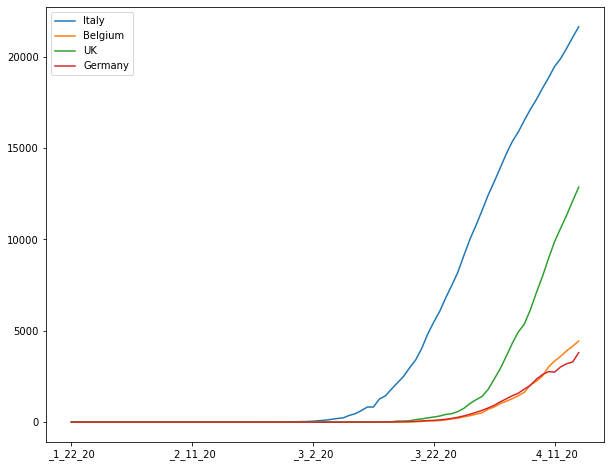

In [9]:
plot_series(df)

## Daily death - by country

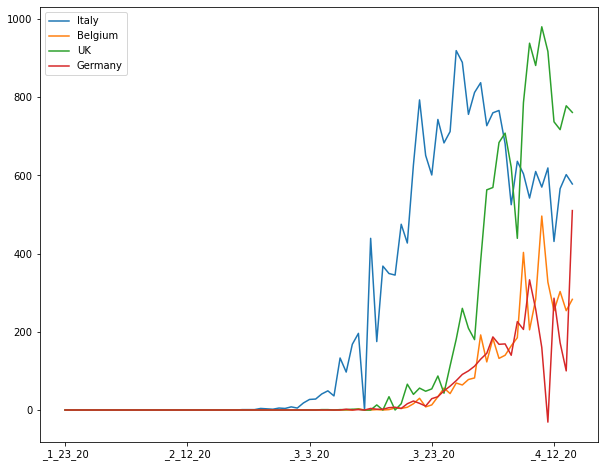

In [10]:
plot_series(linear_increase)

## Number of day to double the death count - by country
( The higher the better, means the country is flattening the curve )

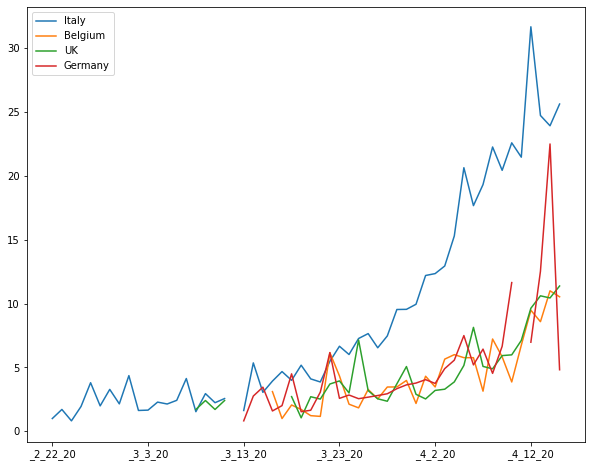

In [11]:
plot_series(exp_increase)